In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

### 1. Spectrum interpolator from fermipy

In [2]:
class dNdEInterpolator(object):
    def __init__(self):
        data = np.loadtxt("../../fermipy/fermipy/data/gammamc_dif.dat")
        EdNdE = data.reshape((12, 24, 250))  # N_channels, N_masses, N_x
        m_GeV = np.array([2.0, 4.0, 6.0, 8.0, 10.0,
                          25.0, 50.0, 80.3, 91.2, 100.0,
                          150.0, 176.0, 200.0, 250.0, 350.0, 500.0, 750.0,
                          1000.0, 1500.0, 2000.0, 3000.0, 5000.0, 7000.0, 1E4])
        # Channel to index
        channel_to_idx = {'cc': 0, 'bb': 1, 'tt': 2, 'tautau': 3, 'ww': 4, 'zz': 5, 'mumu': 6,
                          'gg': 7, 'ee': 8, 'ss': 9, 'uu': 10, 'dd': 11}
        # x = log10(E/M_chi)
        ndec = 10.0
        xedge = np.linspace(0, 1.0, 251)
        x = 0.5 * (xedge[1:] + xedge[:-1]) * ndec - ndec

        ednde_interp = {chan: RegularGridInterpolator([m_GeV, x],
                                                      EdNdE[ichan, :, :],
                                                      bounds_error=False,
                                                      fill_value=None)
                       for chan, ichan in channel_to_idx.items()}
        self.m = m_GeV
        self.x = x
        self.EdNdE = ednde_interp
        self.channels = channel_to_idx

    def dNdE(self, chan, E, m, is_decay=False):
        """ Energies should be always in GeV, then this will return
        dN/dE in units of GeV^-1.
        """
        if is_decay:
            m = m/2
        x = np.log10(E/m)
        EdNdE = self.EdNdE[chan]((m, x))
        EdNdE[EdNdE < 0 ] = 0
        return EdNdE/E

interp = dNdEInterpolator()

### 2. Calculate weighted mean energy

In [3]:
E_obs = np.array([5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
                  5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
                  3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
                  1.00000000e+06])*1E-3
alpha = -2.0
if alpha == -2:
    Eeff = np.log(E_obs[1:]/E_obs[:-1])/(1/E_obs[:-1]-1/E_obs[1:])
else:
    rat_alpha = ((alpha+1)/(alpha+2))
    num = (E_obs[1:]**(alpha+2)-E_obs[:-1]**(alpha+2))
    den = (E_obs[1:]**(alpha+1)-E_obs[:-1]**(alpha+1))
    Eeff = rat_alpha*num/den

### 3. Load annihilation and decay data

In [4]:
d = np.load("F_ann.npz")
res_F_ann = {k: (F, covF, np.linalg.inv(covF)) for k, F, covF in zip(d['names'], d['F'], d['covF'])}
d = np.load("F_decay.npz")
res_F_dec = {k: (F, covF, np.linalg.inv(covF)) for k, F, covF in zip(d['names'], d['F'], d['covF'])}

### 4. Constrain $\langle \sigma v\rangle$ and $\Gamma$ 
In all cases we fit $F(\epsilon)$ to a linear model
$$
F(\epsilon)=A\,q(\epsilon)
$$
with $A=\langle\sigma v\rangle$ or $\Gamma$ for annihilation and decay, respectively, and
$$
q(\epsilon)=\left\{\begin{array}{ll}
\frac{1}{m_\chi^2}\frac{dN}{d\epsilon} & {\rm Ann.}\\
\frac{1}{m_\chi}\frac{dN}{d\epsilon} & {\rm Decay}
\end{array}
\right.
$$

In [5]:
masses_GeV = {'cc': 1.27, 'bb': 4.18, 'tt': 160., 'uu': 0.00216, 'dd': 0.00467, 'ss': 0.093,
              'gg': 0.0, 'ee': 0.0005, 'ww': 80.4, 'zz': 91.2, 'mumu': 0.106, 'tautau': 1.776}

def get_sigmav(masses, channel, F, icovF):
    """<sigma v> in units of cm^3 s^-1"""
    sigv_s = np.zeros_like(masses)
    errs_sigv = np.zeros_like(masses)
    chi2_s = np.zeros_like(masses)
    mass_thr = masses_GeV[channel]
    for im, mass in enumerate(masses):
        if mass < mass_thr:
            continue
        q = interp.dNdE(channel, Eeff, mass)/mass**2
        var = 1/np.dot(q, np.dot(icovF, q))
        sigv = var*np.dot(q, np.dot(icovF, F))
        sig_sigv = np.sqrt(var)
        res = F-q*sigv
        chi2 = np.dot(res, np.dot(icovF, res))
        sigv_s[im] = sigv
        errs_sigv[im] = sig_sigv
        chi2_s[im] = chi2
    return sigv_s, errs_sigv, chi2_s


def get_Gamma(masses, channel, F, icovF):
    """Gamma in units of s^-1"""
    Gamma_s = np.zeros_like(masses)
    errs_Gamma = np.zeros_like(masses)
    chi2_s = np.zeros_like(masses)
    mass_thr = masses_GeV[channel]
    for im, mass in enumerate(masses):
        if mass < 2*mass_thr:
            continue
        dNdE = interp.dNdE(channel, Eeff, mass,
                           is_decay=True)
        q = dNdE/mass
        var = 1/np.dot(q, np.dot(icovF, q))
        Gamma = var*np.dot(q, np.dot(icovF, F))
        sig_Gamma = np.sqrt(var)
        res = F-q*Gamma
        chi2 = np.dot(res, np.dot(icovF, res))
        Gamma_s[im] = Gamma
        errs_Gamma[im] = sig_Gamma
        chi2_s[im] = chi2
    return Gamma_s, errs_Gamma, chi2_s

Run for all channels

In [6]:
m = np.geomspace(2,400,30) #GeV
channels = list(masses_GeV.keys())

res_sigv = {}
res_Gamma = {}
for ch in channels:
    print(ch)
    sigv, err_sigv, chi2_sigv = get_sigmav(m, ch, res_F_ann['total'][0], res_F_ann['total'][2])
    res_sigv[ch] = {'sigv': sigv, 'err': err_sigv, 'chi2': chi2_sigv}
    Gamma, err_Gamma, chi2_Gamma = get_Gamma(m, ch, res_F_dec['total'][0], res_F_dec['total'][2])
    res_Gamma[ch] = {'Gamma': Gamma, 'err': err_Gamma, 'chi2': chi2_Gamma}

cc
bb
tt
uu
dd
ss
gg
ee
ww
zz
mumu
tautau


### 5. Plot results!
In the figures below we plot the 95% upper bound as $A+2\sigma(A)$.

In [7]:
colors = dict(zip(channels, ['b','r','g','m', 'c','k',
                             'gold','tab:olive', 'lightsalmon',
                             'mediumslateblue','orange','mediumspringgreen']))

Text(0, 0.5, '$\\langle \\sigma v\\rangle\\,\\,[{\\rm cm}^3\\,{\\rm s}^{-1}]$')

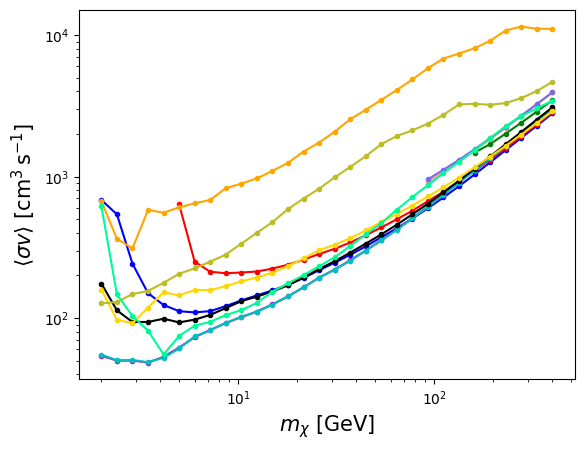

In [8]:
plt.figure()
for chan in channels:
    col = colors[chan]
    sigv = 1E26*res_sigv[chan]['sigv']
    err = 1E26*res_sigv[chan]['err']
    good = err > 0
    plt.plot(m[good], sigv[good]+2*err[good], '.-', color=col)
plt.loglog()
plt.xlabel(r'$m_\chi\,\,[{\rm GeV}]$', fontsize=15)
plt.ylabel(r'$\langle \sigma v\rangle\,\,[{\rm cm}^3\,{\rm s}^{-1}]$', fontsize=15)


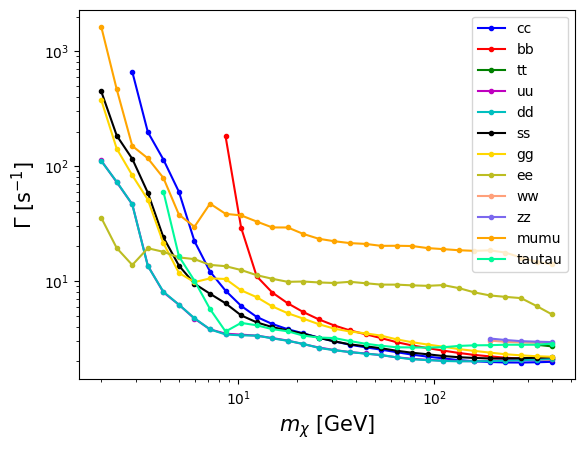

In [9]:
plt.figure()
for chan in channels:
    col = colors[chan]
    Gamma = 1E27*res_Gamma[chan]['Gamma']
    err = 1E27*res_Gamma[chan]['err']
    good = err > 0
    plt.plot(m[good], Gamma[good]+2*err[good], '.-', color=col, label=chan)
plt.loglog()
plt.xscale('log')
plt.xlabel(r'$m_\chi\,\,[{\rm GeV}]$', fontsize=15)
plt.ylabel(r'$\Gamma\,\,[{\rm s}^{-1}]$', fontsize=15)
plt.legend()